# **Automated Hate Speech Detection and the Problem of Offensive Language**

## **Introduction**

Dans ce notebook, on travaille sur la détection automatique de discours de haine dans des textes courts.
On commence par nettoyer les textes, extraire des caractéristiques (TF-IDF, POS, etc.), puis on entraîne des modèles de machine learning.

L'objectif de ce projet est de reproduire les résultats de l'article "Automated Hate Speech Detection and the Problem of Offensive Language" rédigé par Thomas Davidson, Dana Warmsley, Michael Macy et Ingmar Weber en 2017.
L'étude originale porte sur la classification automatique de tweets en trois catégories : discours haineux, langage offensant, et langage neutre.

En plus de la reproduction des résultats, nous apporterons des ajustements, des optimisations et des réflexions complémentaires.



## **Data**

Dans ce projet, nous allons utiliser deux jeux de données différents pour tester nos modèles de détection de discours haineux :

**labeled_data.csv**
→ Ce dataset est utilisé dans l'article original de Davidson et al. Il contient des tweets annotés selon trois classes :

0 : Hate Speech

1 : Offensive Language

2 : Neither (langage neutre)
Cela nous permet de faire de la classification multi-classes.

**Multitarget-CONAN.csv**
→ Ce dataset est plus récent et en français. Il contient des commentaires annotés avec :

HATE_SPEECH (discours haineux ou pas)

TARGET (la cible du discours haineux, par ex : religion, origine, genre, etc.)
Ce jeu de données est utilisé pour de la classification binaire (haineux vs neutre) et pour analyser contre qui les messages sont dirigés.

**FTR_new_labels.csv**
Ce jeu de données contient 2 856 tweets en français, annotés manuellement pour la détection de discours haineux. Les données sont organisées en trois colonnes :

id : identifiant unique du tweet.

tweet : le contenu textuel des tweets.

label : catégorie binaire indiquant :

0 : Tweet considéré comme neutre (non-haineux).

1 : Tweet considéré comme haineux.

Répartition des données :

Neutre (0) : 1 929 tweets (~68%).

Haineux (1) : 927 tweets (~32%).



## **Plan**
Voici les grandes étapes que nous allons suivre :

**Chargement et préparation des données**
- On commence par importer les deux jeux de données et faire un nettoyage de base pour pouvoir travailler proprement.

**Reproduction du modèle de l'article**
- On essaye de reproduire aussi fidèlement que possible la méthode proposée dans "Automated Hate Speech Detection and the Problem of Offensive Language" (Davidson et al., 2017).

**Développement de nos propres modèles**
- On propose ensuite d'autres approches (modèles plus récents, ajout de nouvelles features, etc.) pour tenter d'améliorer les résultats.

**Analyses et évaluations supplémentaires**
- Enfin, on réalise des analyses plus poussées (graphiques, matrice de confusion, importance des features, etc.) pour mieux comprendre le comportement des modèles.

# ***1. Chargement et préparation des données***

In [ ]:
!pip install vaderSentiment
!pip install textstat
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
import warnings
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
import nltk
from nltk.corpus import cmudict
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('cmudict')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
!pip install imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data = pd.read_csv("labeled_data.csv")
data_conan = pd.read_csv("labeled_data.csv")

In [ ]:
tweets=data.tweet


In [ ]:

warnings.simplefilter(action='ignore', category=FutureWarning)
stopwords=stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
# The get_feature_names method has been renamed to get_feature_names_out
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.

    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)

    words = preprocess(tweet) #Get text only

    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))

    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)

    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]
feats = get_feature_array(tweets)
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  warnings.warn(


# **2. Reproduction du modèle de l'article (Moderniser)**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Rapport de classification (pipeline fidèle à l'article) :
              precision    recall  f1-score   support

        Hate       0.34      0.43      0.38       143
   Offensive       0.93      0.87      0.90      1920
     Neither       0.66      0.81      0.73       416

    accuracy                           0.83      2479
   macro avg       0.64      0.70      0.67      2479
weighted avg       0.85      0.83      0.84      2479



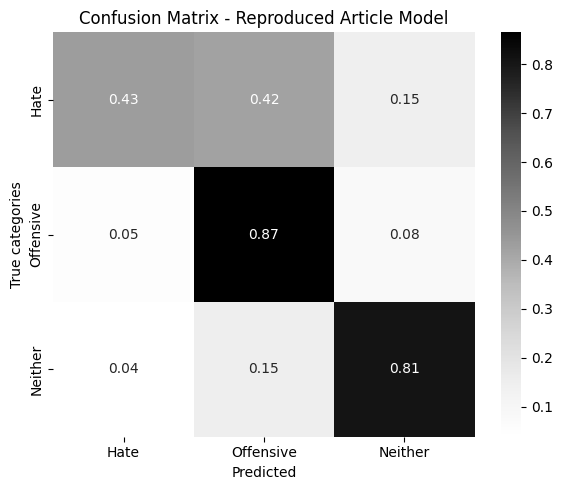

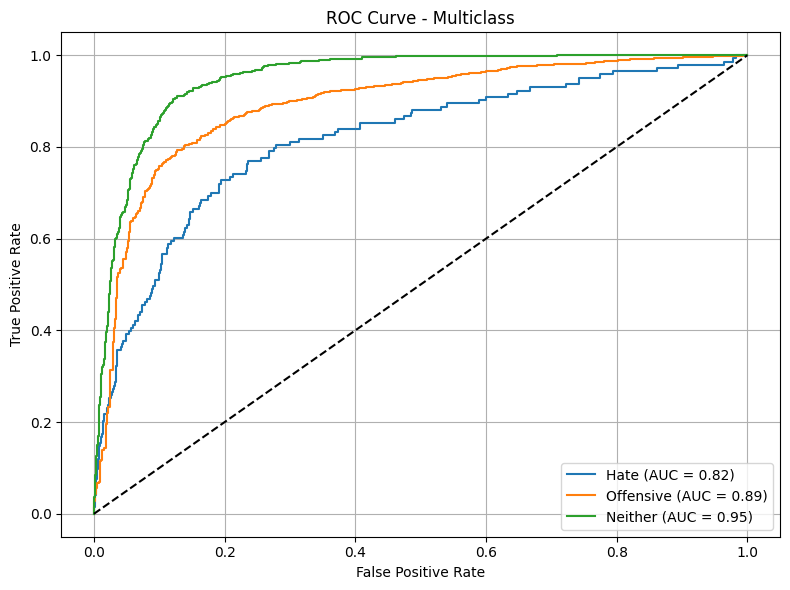

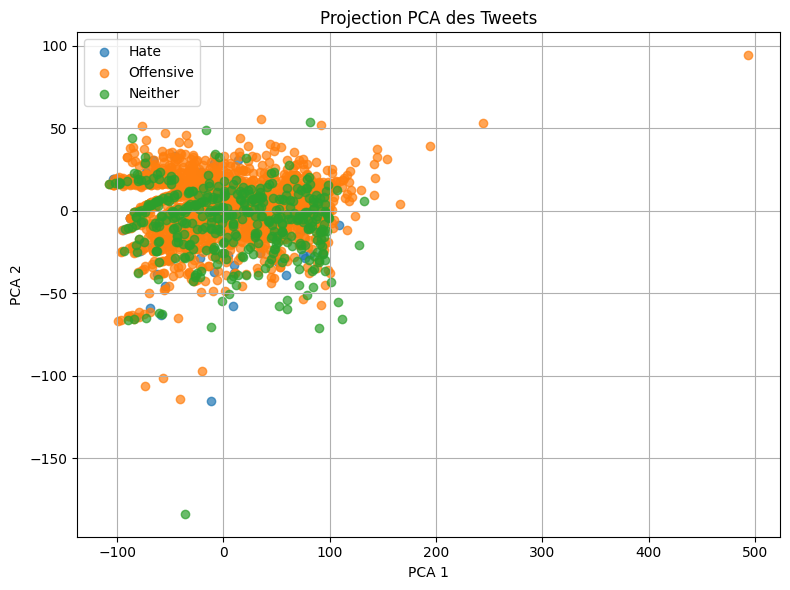

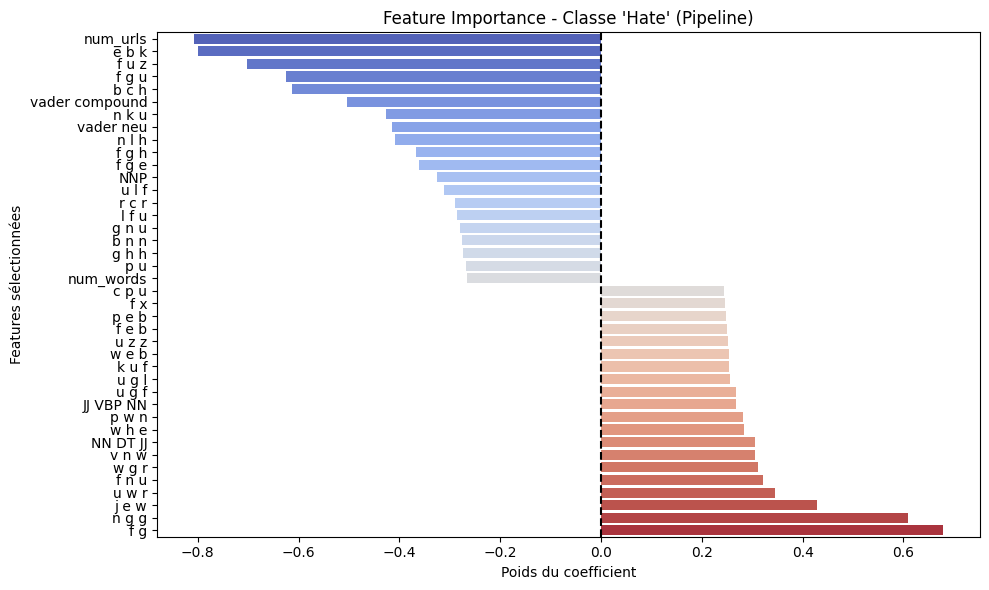

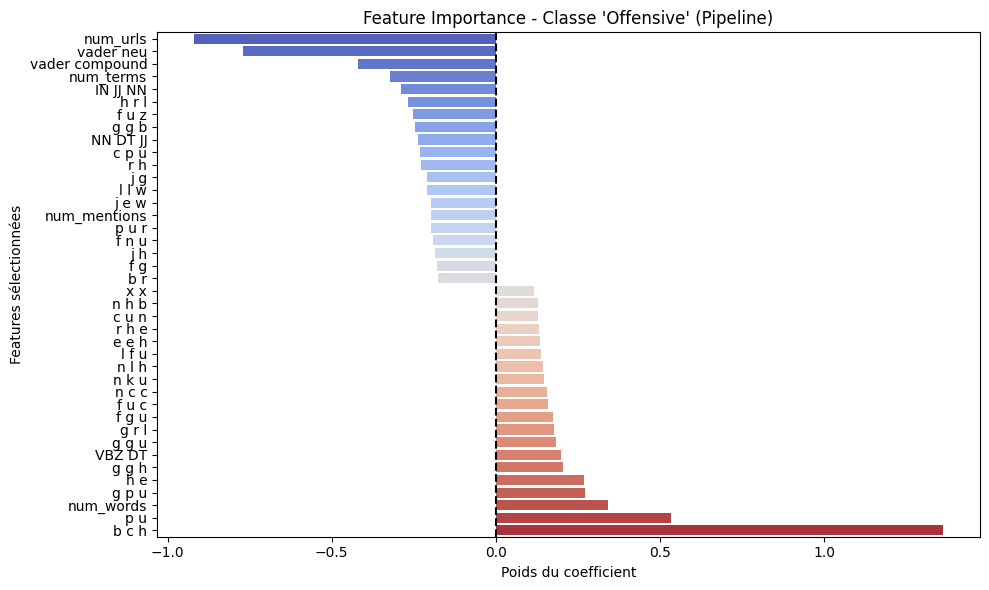

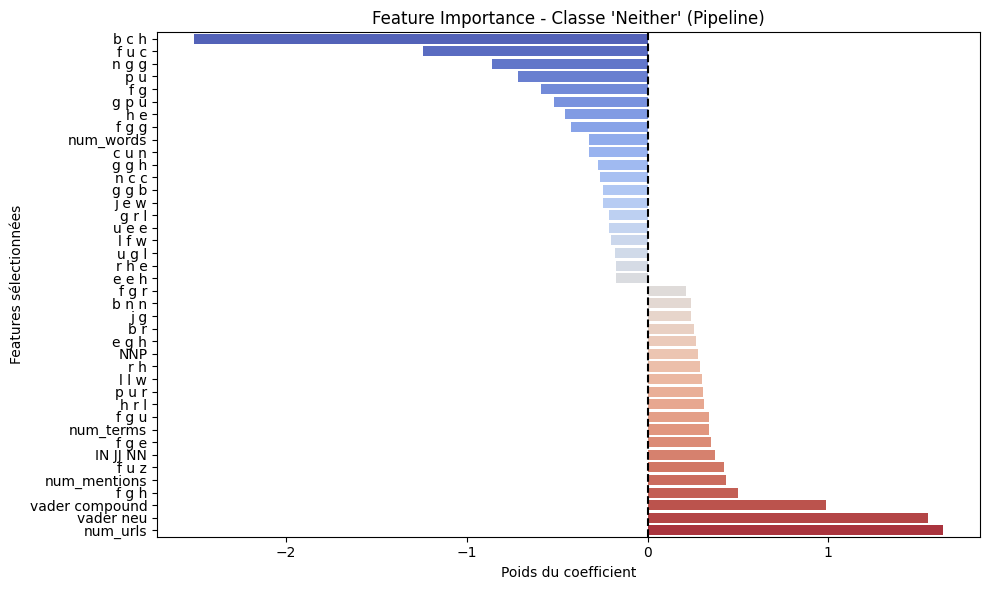

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Chargement
X = pd.DataFrame(M)
y = data['class'].astype(int)

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# 3. Pipeline
pipe = Pipeline([
    ('select', SelectFromModel(
        LogisticRegression(
            class_weight='balanced',
            penalty='l1',
            C=0.01,
            solver='liblinear',
            max_iter=10000
        )
    )),
    ('model', LogisticRegression(
        penalty='l2',
        C=1.0,
        class_weight='balanced',
        solver='liblinear',
        max_iter=10000
    ))
])

# 4. Cross-Validation
param_grid = {}
grid = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

# 5. Évaluation
y_pred = grid.predict(X_test)
print("Rapport de classification (pipeline fidèle à l'article) :")
print(classification_report(y_test, y_pred, target_names=['Hate', 'Offensive', 'Neither']))

# 6. Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True categories")
plt.title("Confusion Matrix - Reproduced Article Model")
plt.tight_layout()
plt.show()

# 7. ROC Curve (multiclass)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_score = grid.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_score[:, i])

# Courbe ROC
plt.figure(figsize=(8, 6))
for i, label in enumerate(['Hate', 'Offensive', 'Neither']):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multiclass')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# 8. PCA Projection
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8, 6))
palette = {0: 'blue', 1: 'grey', 2: 'red'}
for class_value in np.unique(y_test):
    plt.scatter(
        X_test_pca[y_test == class_value, 0],
        X_test_pca[y_test == class_value, 1],
        label=labels[class_value],
        alpha=0.7
    )
plt.title('Projection PCA des Tweets')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Étape 1 : Récupérer le modèle final
selector = grid.best_estimator_.named_steps['select']
final_model = grid.best_estimator_.named_steps['model']

# Étape 2 : Extraire les noms des features sélectionnées
selected_mask = selector.get_support()
selected_features = np.array(feature_names)[selected_mask]
selected_coefs = final_model.coef_[0]  # Multi-classe : on pourrait aussi afficher par classe

# Étape 3 : Afficher les features les plus influentes (pour chaque classe)
for class_index, class_label in enumerate(['Hate', 'Offensive', 'Neither']):
    coefs = final_model.coef_[class_index]
    top_n = 20
    top_pos_idx = np.argsort(coefs)[-top_n:]
    top_neg_idx = np.argsort(coefs)[:top_n]
    top_idx = np.concatenate([top_neg_idx, top_pos_idx])
    top_features = selected_features[top_idx]
    top_weights = coefs[top_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_weights, y=top_features, palette="coolwarm")
    plt.title(f"Feature Importance - Classe '{class_label}' (Pipeline)")
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Poids du coefficient")
    plt.ylabel("Features sélectionnées")
    plt.tight_layout()
    plt.show()



# **3. Développement de nos propres modèles**

## **Modèle à un niveaux sur labeled_data avec features - LogisticRegressionCV (7mins)**

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Résultats avec LogisticRegressionCV :
              precision    recall  f1-score   support

        Hate       0.24      0.53      0.33       290
   Offensive       0.94      0.79      0.86      3832
     Neither       0.61      0.80      0.69       835

    accuracy                           0.78      4957
   macro avg       0.60      0

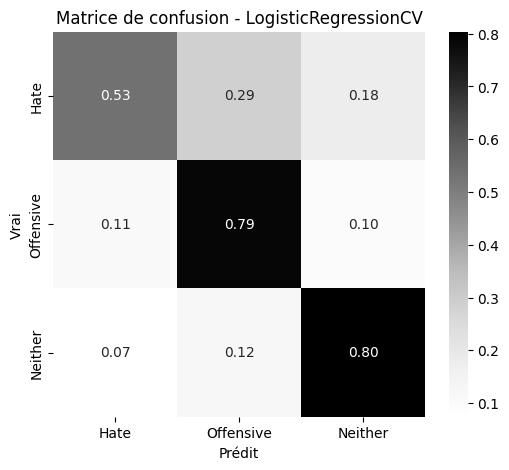

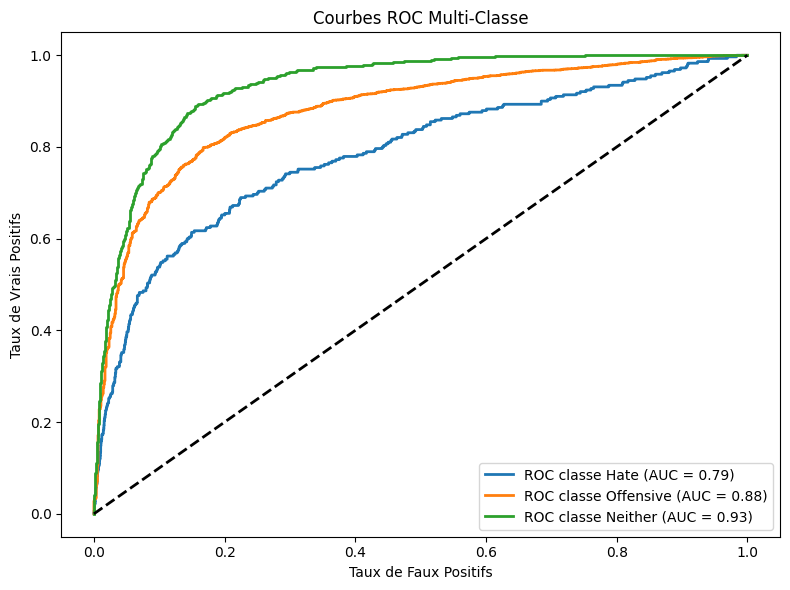

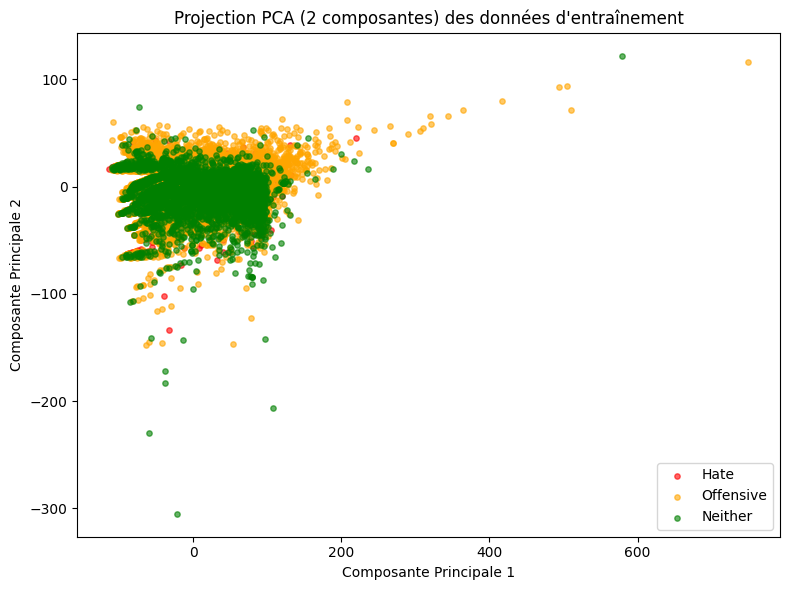

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize


# 1. Re-vectoriser en allégeant la taille
vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )
X = pd.DataFrame(M)
y = data['class']


# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Modèle LogisticRegression avec Cross-Validation intégrée
model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10],
    cv=5,
    max_iter=1000,
    class_weight='balanced',
    scoring='f1_macro',
    solver='liblinear',
    verbose=1
)

model.fit(X_train, y_train)

# 5. Prédictions + rapport
y_pred = model.predict(X_test)
print("Résultats avec LogisticRegressionCV :")
print(classification_report(y_test, y_pred, target_names=['Hate', 'Offensive', 'Neither']))


y_true_bin_lr = label_binarize(y_test, classes=[0, 1, 2])
y_score_lr = model.predict_proba(X_test)
nom_modele_lr = "LogRegCV"


# 6. Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion - LogisticRegressionCV")
plt.show()


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import numpy as np

# --- Suite du code existant --- #

# 7. Courbe ROC multi-classe
classes = ['Hate', 'Offensive', 'Neither']
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC classe {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multi-Classe')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 8. PCA pour visualisation des données
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
for idx, label in enumerate(np.unique(y_train)):
    plt.scatter(X_pca[y_train == label, 0], X_pca[y_train == label, 1],
                c=colors[idx], label=classes[label], alpha=0.6, s=15)

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection PCA (2 composantes) des données d\'entraînement')
plt.legend()
plt.tight_layout()
plt.show()



## **Modèle à un niveaux sur labeled_data avec features - SVMM** (36mins)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


🎯 Résultats SVM optimisé
              precision    recall  f1-score   support

        Hate       0.28      0.36      0.32       164
   Offensive       0.91      0.87      0.89      1905
     Neither       0.66      0.71      0.69       410

    accuracy                           0.81      2479
   macro avg       0.61      0.65      0.63      2479
weighted avg       0.82      0.81      0.81      2479



<ipython-input-14-de210a299704>:44: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


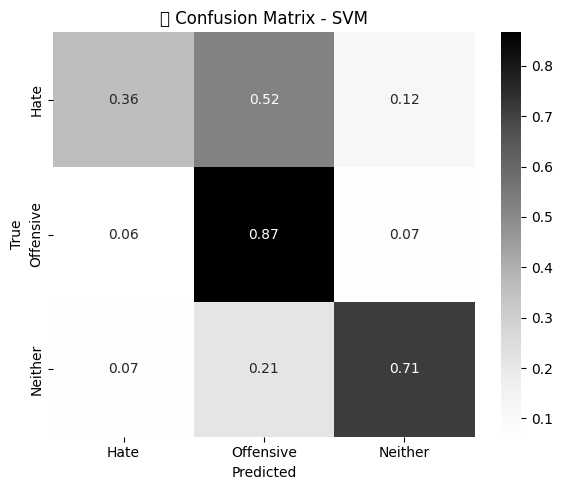

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split
X = csr_matrix(M)  # t'assure que c'est bien sparse pour SVM
y = data['class'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# 2. SVM avec GridSearch sur C
param_grid = {'C': [0.01, 0.1, 1, 10]}

grid = GridSearchCV(
    estimator=LinearSVC(class_weight='balanced', max_iter=5000),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    verbose=1
)

grid.fit(X_train, y_train)
svm_model = grid.best_estimator_

# 3. Évaluation
y_pred = svm_model.predict(X_test)
print("Résultats SVM optimisé")
print(classification_report(y_test, y_pred, target_names=['Hate', 'Offensive', 'Neither']))

# 4. Matrice
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM")
plt.tight_layout()
plt.show()


## **Modèle à deux niveaux sur labeled_data sans features (Logistic Regression + Random Classifer)**

                    precision    recall  f1-score   support

       Hate Speech       0.91      0.83      0.87      1430
Offensive Language       0.95      0.98      0.96     19190
           Neither       0.92      0.80      0.85      4163

          accuracy                           0.94     24783
         macro avg       0.93      0.87      0.90     24783
      weighted avg       0.94      0.94      0.94     24783



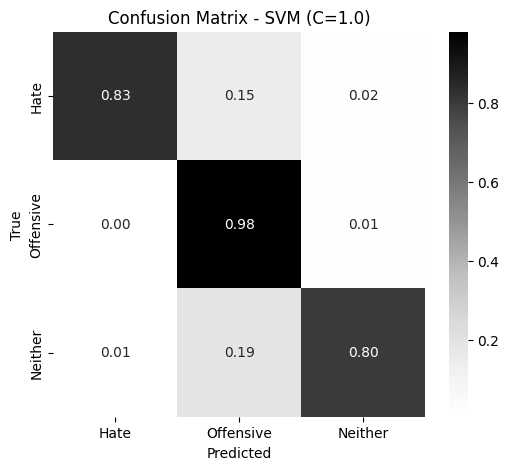

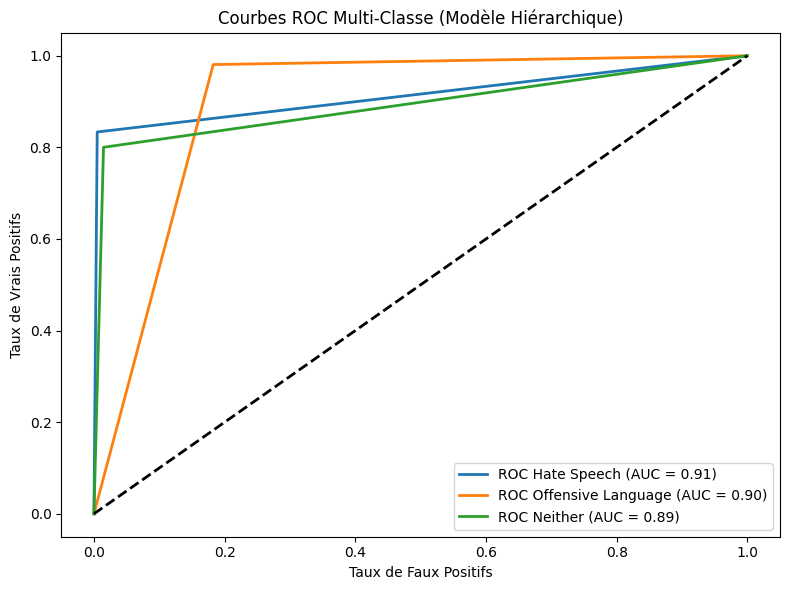

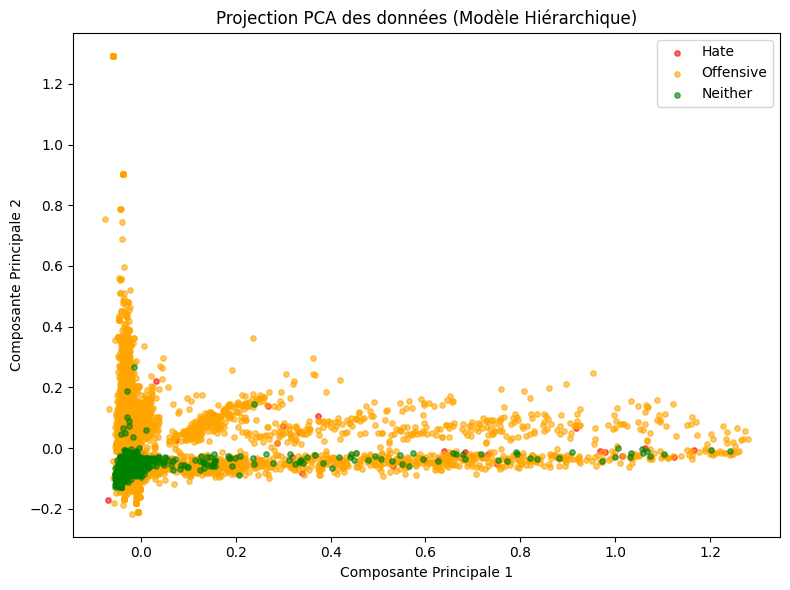

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report,  confusion_matrix
import seaborn as sns
# Étape 1 : Données prétraitées
data = data[data['class'].isin([0, 1, 2])].copy()
data['clean_tweet'] = data['tweet'].apply(preprocess)

# === Niveau 1 : Offensive (1) vs Neither (2) ===
data_lvl1 = data[data['class'].isin([1, 2])]
X1_train, X1_test, y1_train, y1_test = train_test_split(data_lvl1['clean_tweet'], data_lvl1['class'], test_size=0.2, random_state=42)

tfidf1 = TfidfVectorizer(ngram_range=(1, 3), min_df=5, preprocessor=preprocess)
X1_train_tfidf = tfidf1.fit_transform(X1_train)
X1_test_tfidf = tfidf1.transform(X1_test)

clf_lvl1 = LogisticRegression(solver='liblinear')
clf_lvl1.fit(X1_train_tfidf, y1_train)

# === Niveau 2 : Hate Speech (0) vs le reste ===
data_lvl2 = data.copy()
data_lvl2['binary_hate'] = data_lvl2['class'].apply(lambda x: 1 if x == 0 else 0)

X2_train, X2_test, y2_train, y2_test = train_test_split(data_lvl2['clean_tweet'], data_lvl2['binary_hate'], test_size=0.2, random_state=42)

tfidf2 = TfidfVectorizer(ngram_range=(1, 3), min_df=5, preprocessor=preprocess)
X2_train_tfidf = tfidf2.fit_transform(X2_train)
X2_test_tfidf = tfidf2.transform(X2_test)

# Oversampling sur le modèle Hate vs reste
ros = RandomOverSampler(random_state=42)
X2_train_ros, y2_train_ros = ros.fit_resample(X2_train_tfidf, y2_train)

clf_lvl2 = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_lvl2.fit(X2_train_ros, y2_train_ros)

# === Prédictions combinées ===
X_all_lvl1 = tfidf1.transform(data['clean_tweet'])
X_all_lvl2 = tfidf2.transform(data['clean_tweet'])

pred_lvl2 = clf_lvl2.predict(X_all_lvl2)

final_preds = []
for i in range(len(data)):
    if pred_lvl2[i] == 1:
        final_preds.append(0)  # Hate Speech
    else:
        pred = clf_lvl1.predict(X_all_lvl1[i])
        final_preds.append(pred[0])  # Offensive or Neither

# === Évaluation finale ===
print(classification_report(data['class'], final_preds, target_names=['Hate Speech', 'Offensive Language', 'Neither']))


cm = confusion_matrix(data['class'], final_preds, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - SVM (C=1.0)")
plt.show()


y_true_bin_hier1 = label_binarize(data['class'], classes=[0, 1, 2])
y_score_hier1 = label_binarize(final_preds, classes=[0, 1, 2])
nom_modele_hier1 = "Hiérarchique_LogReg+RF"


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

# --- Suite du code existant --- #

# ROC Multi-classe (One-vs-Rest)
y_true_bin = label_binarize(data['class'], classes=[0, 1, 2])
y_pred_bin = label_binarize(final_preds, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(['Hate Speech', 'Offensive Language', 'Neither']):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multi-Classe (Modèle Hiérarchique)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PCA pour visualisation des données
# Combinaison des deux TF-IDF pour PCA
from scipy.sparse import hstack
X_combined = hstack([X_all_lvl1, X_all_lvl2])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined.toarray())

plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
for idx, label in enumerate(np.unique(data['class'])):
    plt.scatter(X_pca[data['class'] == label, 0], X_pca[data['class'] == label, 1],
                c=colors[idx], label=labels[label], alpha=0.6, s=15)

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection PCA des données (Modèle Hiérarchique)')
plt.legend()
plt.tight_layout()
plt.show()


## **Modèle à deux niveaux sur labeled_data avec features (Logistic Regression + Random Classifer)**

Rapport final - Classifieur 2 étages sur M
              precision    recall  f1-score   support

        Hate       0.96      0.82      0.89      1430
   Offensive       0.97      0.98      0.97     19190
     Neither       0.89      0.90      0.90      4163

    accuracy                           0.96     24783
   macro avg       0.94      0.90      0.92     24783
weighted avg       0.96      0.96      0.96     24783



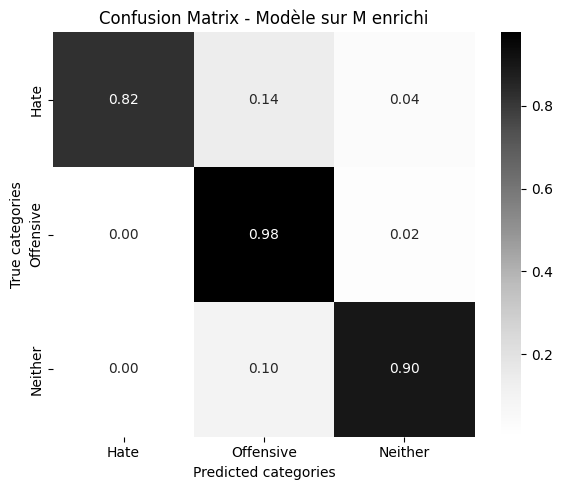

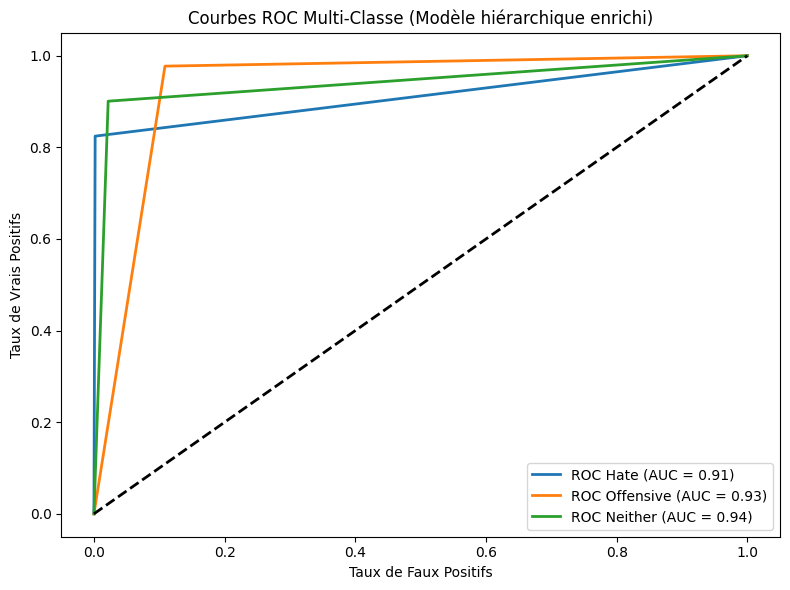

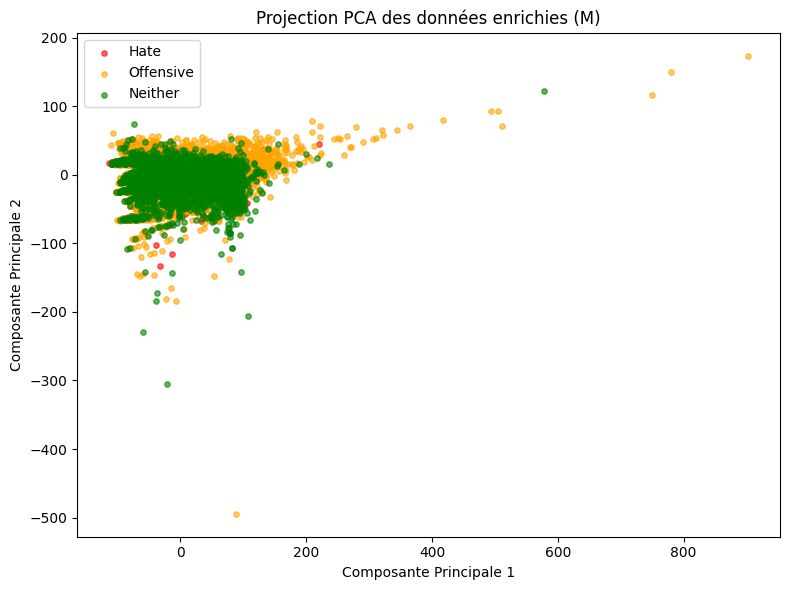

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Chargement des features enrichies (M) et des classes
X_full = pd.DataFrame(M)
y_full = data['class']

# --- Niveau 1 : Offensive (1) vs Neither (2)
mask_lvl1 = y_full.isin([1, 2])
X_lvl1 = X_full[mask_lvl1]
y_lvl1 = y_full[mask_lvl1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X_lvl1, y_lvl1, test_size=0.2, random_state=42)

clf_lvl1 = LogisticRegression(solver='liblinear', max_iter=1000)
clf_lvl1.fit(X1_train, y1_train)

# --- Niveau 2 : Hate Speech (0) vs le reste
y_lvl2 = y_full.apply(lambda x: 1 if x == 0 else 0)  # 1 = Hate, 0 = All others
X2_train, X2_test, y2_train, y2_test = train_test_split(X_full, y_lvl2, test_size=0.2, random_state=42)

# Oversampling classe 1 (Hate Speech)
ros = RandomOverSampler(random_state=42)
X2_train_ros, y2_train_ros = ros.fit_resample(X2_train, y2_train)

clf_lvl2 = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
clf_lvl2.fit(X2_train_ros, y2_train_ros)

# === Prédictions finales ===
pred_lvl2 = clf_lvl2.predict(X_full)

final_preds = []
for i in range(len(X_full)):
    if pred_lvl2[i] == 1:
        final_preds.append(0)  # Hate Speech
    else:
        pred_lvl1 = clf_lvl1.predict(X_full.iloc[[i]])[0]
        final_preds.append(pred_lvl1)  # Offensive or Neither

# === Évaluation ===
print("Rapport final - Classifieur 2 étages sur M")
print(classification_report(y_full, final_preds, target_names=['Hate', 'Offensive', 'Neither']))

# Matrice de confusion
cm = confusion_matrix(y_full, final_preds, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted categories")
plt.ylabel("True categories")
plt.title("Confusion Matrix - Modèle sur M enrichi")
plt.tight_layout()
plt.show()

y_true_bin_hier2 = label_binarize(y_full, classes=[0, 1, 2])
y_score_hier2 = label_binarize(final_preds, classes=[0, 1, 2])
nom_modele_hier2 = "Hiérarchique_Features"

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

# --- Suite du code existant --- #

# Courbe ROC Multi-classe (One-vs-Rest)
y_true_bin = label_binarize(y_full, classes=[0, 1, 2])
y_pred_bin = label_binarize(final_preds, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(['Hate', 'Offensive', 'Neither']):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multi-Classe (Modèle hiérarchique enrichi)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# PCA pour visualisation des données enrichies
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_full)

plt.figure(figsize=(8, 6))
colors = ['red', 'orange', 'green']
for idx, label in enumerate(np.unique(y_full)):
    plt.scatter(X_pca[y_full == label, 0], X_pca[y_full == label, 1],
                c=colors[idx], label=labels[label], alpha=0.6, s=15)

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection PCA des données enrichies (M)')
plt.legend()
plt.tight_layout()
plt.show()



## **Modèle à deux niveaux sur labeled_data sans features (Logistic Regression + Logistic Regression)**

Rapport final - Logistic Regression L2 (2 niveaux)
              precision    recall  f1-score   support

        Hate       0.50      0.80      0.62      1430
   Offensive       0.97      0.91      0.94     19190
     Neither       0.82      0.88      0.85      4163

    accuracy                           0.90     24783
   macro avg       0.77      0.87      0.80     24783
weighted avg       0.92      0.90      0.91     24783



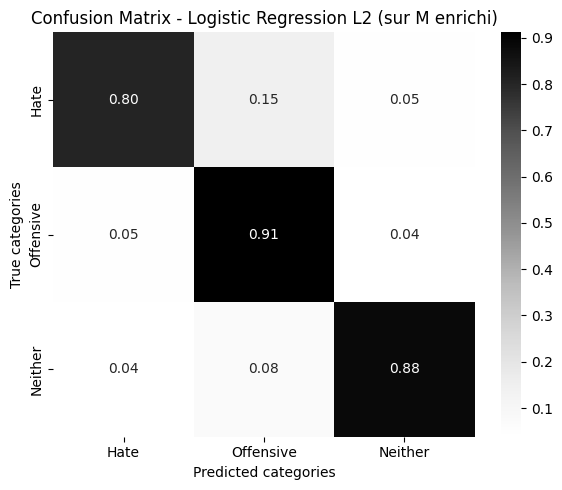

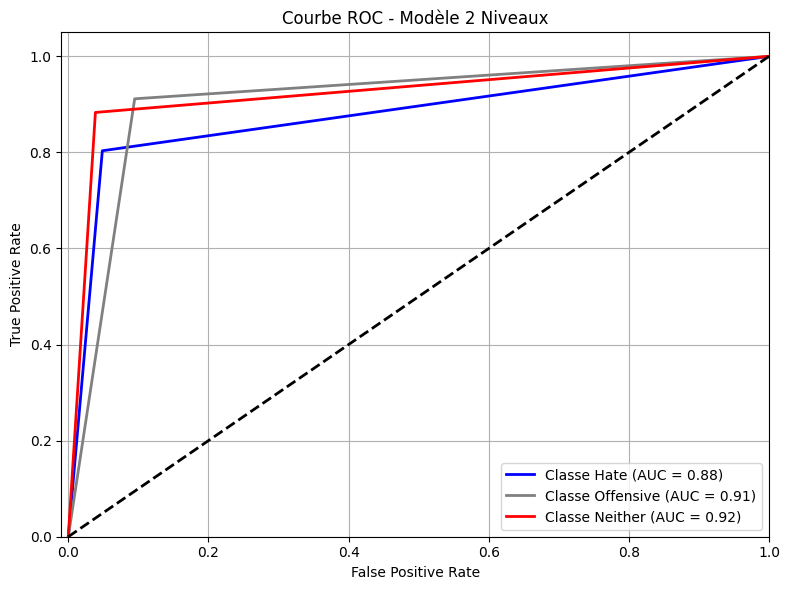

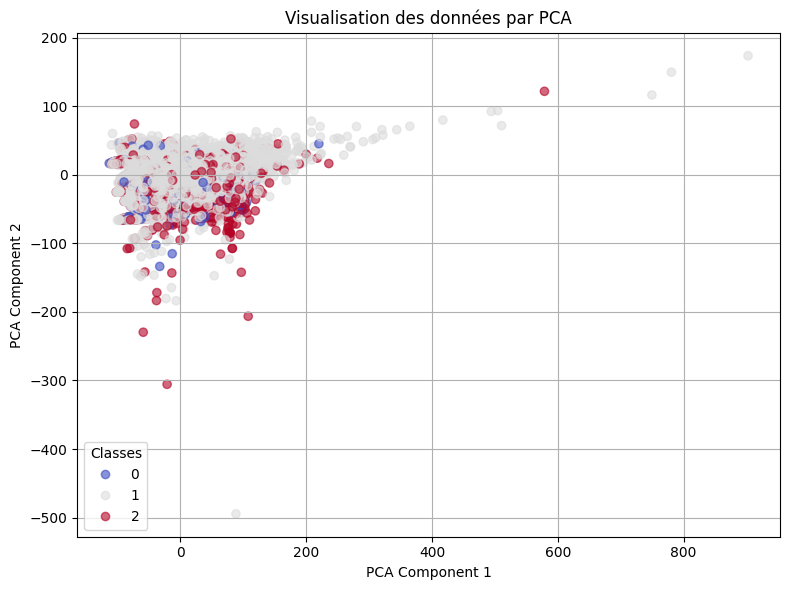

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Chargement des features enrichies (M) et des classes
X_full = pd.DataFrame(M)
y_full = data['class']

# --- Niveau 1 : Offensive (1) vs Neither (2)
mask_lvl1 = y_full.isin([1, 2])
X_lvl1 = X_full[mask_lvl1]
y_lvl1 = y_full[mask_lvl1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X_lvl1, y_lvl1, test_size=0.3, random_state=42)

clf_lvl1 = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    C=1.0
)
clf_lvl1.fit(X1_train, y1_train)

# --- Niveau 2 : Hate Speech (0) vs le reste
y_lvl2 = y_full.apply(lambda x: 1 if x == 0 else 0)  # 1 = Hate, 0 = All others
X2_train, X2_test, y2_train, y2_test = train_test_split(X_full, y_lvl2, test_size=0.3, random_state=42)

# Oversampling classe 1 (Hate Speech)
ros = RandomOverSampler(random_state=42)
X2_train_ros, y2_train_ros = ros.fit_resample(X2_train, y2_train)

clf_lvl2 = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    C=1.0
)
clf_lvl2.fit(X2_train_ros, y2_train_ros)

# === Prédictions finales ===
pred_lvl2 = clf_lvl2.predict(X_full)

final_preds = []
for i in range(len(X_full)):
    if pred_lvl2[i] == 1:
        final_preds.append(0)  # Hate Speech
    else:
        pred_lvl1 = clf_lvl1.predict(X_full.iloc[[i]])[0]
        final_preds.append(pred_lvl1)  # Offensive or Neither

# === Évaluation ===
print("Rapport final - Logistic Regression L2 (2 niveaux)")
print(classification_report(y_full, final_preds, target_names=['Hate', 'Offensive', 'Neither']))

# Matrice de confusion
cm = confusion_matrix(y_full, final_preds, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted categories")
plt.ylabel("True categories")
plt.title("Confusion Matrix - Logistic Regression L2 (sur M enrichi)")
plt.tight_layout()
plt.show()

y_true_bin_loglog = label_binarize(y_full, classes=[0, 1, 2])
y_score_loglog = label_binarize(final_preds, classes=[0, 1, 2])
nom_modele_loglog = "Hiérarchique_LogReg+LogReg"

# === ROC CURVE Multiclasse ===
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarisation des vraies classes et des prédictions
y_full_bin = label_binarize(y_full, classes=[0, 1, 2])
final_preds_bin = label_binarize(final_preds, classes=[0, 1, 2])

# Calcul de la courbe ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_full_bin[:, i], final_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la ROC
plt.figure(figsize=(8, 6))
colors = ['blue', 'grey', 'red']
labels_names = ['Hate', 'Offensive', 'Neither']

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe {labels_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Modèle 2 Niveaux')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# === Analyse PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, cmap='coolwarm', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualisation des données par PCA')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid()
plt.tight_layout()
plt.show()



## **Modèle à un niveaux sur FTR_new_labels sans features (RandomForestClassifier)**

              precision    recall  f1-score   support

      Neutre       0.84      0.84      0.84       386
     Haineux       0.67      0.66      0.67       186

    accuracy                           0.78       572
   macro avg       0.76      0.75      0.75       572
weighted avg       0.78      0.78      0.78       572



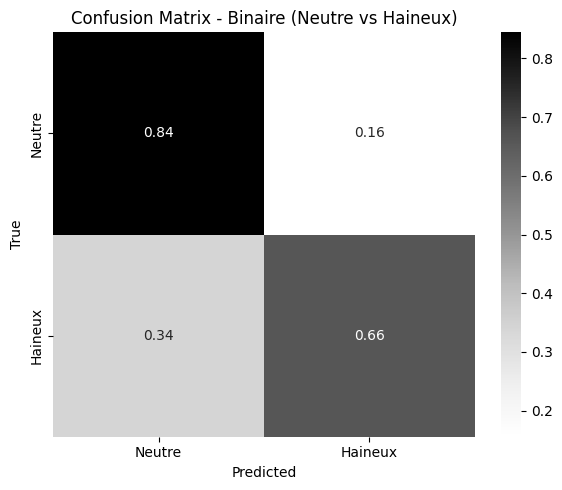

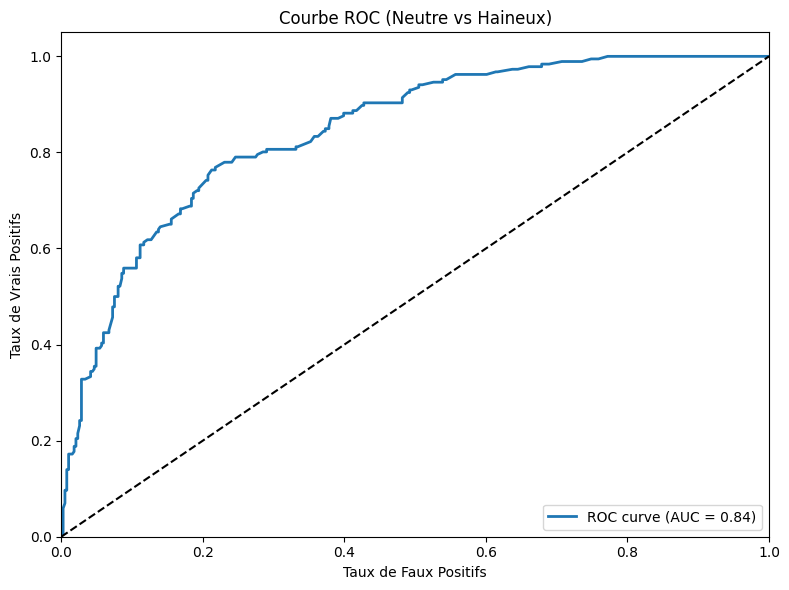

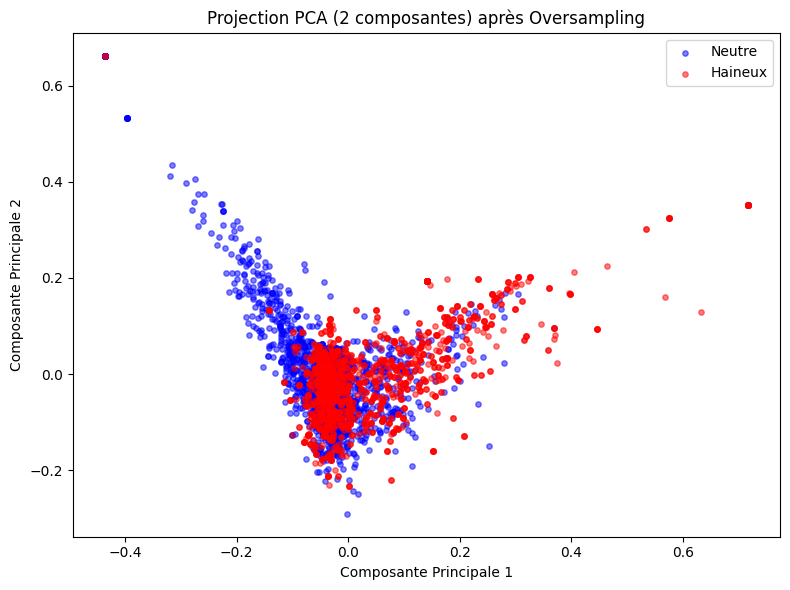

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler

# 1. Charger la nouvelle base
data = pd.read_csv("FTR_new_labels.csv", encoding='latin-1')  # adapte le chemin si besoin

# 2. Nettoyage simple
def preprocess(text_string):
    text_string = re.sub(r"http\S+", "", text_string)  # remove urls
    text_string = re.sub(r"@\w+", "", text_string)     # remove mentions
    text_string = re.sub(r"#\w+", "", text_string)     # remove hashtags
    text_string = re.sub(r"[^A-Za-z0-9\s]", "", text_string)  # remove punctuation
    text_string = re.sub(r"\s+", " ", text_string).strip()
    return text_string.lower()

data['clean_text'] = data['tweet'].astype(str).apply(preprocess)

# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['label'], test_size=0.2, stratify=data['label'], random_state=42
)

# 4. TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 5. Oversampling sur la classe minoritaire (haineux)
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_tfidf, y_train)

# 6. Modèle Random Forest (ou Logistic Regression si tu veux)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_ros, y_train_ros)

# 7. Prédictions
y_pred = model.predict(X_test_tfidf)

# 8. Rapport
print(classification_report(y_test, y_pred, target_names=['Neutre', 'Haineux']))

# 9. Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Neutre', 'Haineux']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Binaire (Neutre vs Haineux)")
plt.tight_layout()
plt.show()


from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

# --- Courbe ROC (binaire) --- #
y_proba = model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC (Neutre vs Haineux)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# --- PCA pour visualiser les données après oversampling --- #
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_ros.toarray())

plt.figure(figsize=(8, 6))
colors = ['blue', 'red']
labels_pca = ['Neutre', 'Haineux']

for idx, label in enumerate(np.unique(y_train_ros)):
    plt.scatter(X_pca[y_train_ros == label, 0], X_pca[y_train_ros == label, 1],
                c=colors[idx], label=labels_pca[label], alpha=0.5, s=15)

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection PCA (2 composantes) après Oversampling')
plt.legend()
plt.tight_layout()
plt.show()


## **Modèle à un niveaux sur FTR_new_labels sans features (Logistic Regression)**

              precision    recall  f1-score   support

      Neutre       0.86      0.80      0.83       193
     Haineux       0.63      0.72      0.67        93

    accuracy                           0.77       286
   macro avg       0.74      0.76      0.75       286
weighted avg       0.78      0.77      0.78       286



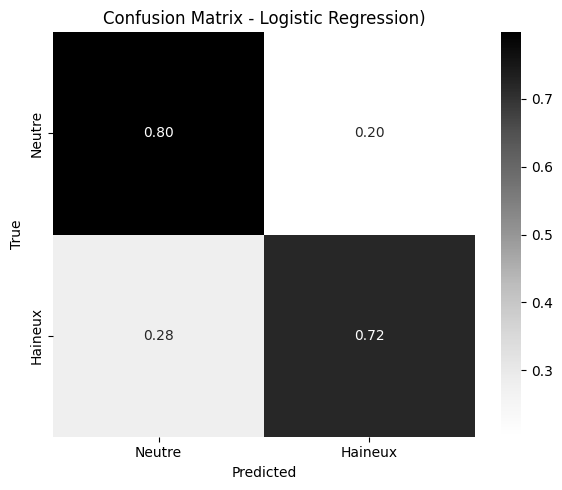

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack

# 1. Charger la base
data = pd.read_csv("FTR_new_labels.csv", encoding='latin-1')  # adapte le chemin si besoin

# 2. Nettoyage et enrichissement
def preprocess(text_string):
    text_string = re.sub(r"http\S+", "", text_string)  # remove urls
    text_string = re.sub(r"@\w+", "", text_string)     # remove mentions
    text_string = re.sub(r"#\w+", "", text_string)     # remove hashtags
    text_string = re.sub(r"[^A-Za-z0-9\s]", "", text_string)  # remove punctuation
    text_string = re.sub(r"\s+", " ", text_string).strip()
    return text_string.lower()

def extra_features(text):
    length = len(text)
    word_count = len(text.split())
    upper_count = sum(1 for c in text if c.isupper())
    exclamations = text.count("!")
    questions = text.count("?")
    return [length, word_count, upper_count, exclamations, questions]

data['clean_text'] = data['tweet'].astype(str).apply(preprocess)
extra_feats = data['tweet'].astype(str).apply(extra_features).tolist()
extra_feats_array = np.array(extra_feats)

# 3. Split
X_train_text, X_test_text, X_train_feats, X_test_feats, y_train, y_test = train_test_split(
    data['clean_text'], extra_feats_array, data['label'], test_size=0.1, stratify=data['label'], random_state=42
)

# 4. TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# 5. Fusion TF-IDF + autres features
X_train_combined = hstack([X_train_tfidf, X_train_feats])
X_test_combined = hstack([X_test_tfidf, X_test_feats])

# 6. Modèle Logistic Regression
model = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    C=1.0,
    max_iter=1000
)
model.fit(X_train_combined, y_train)

# 7. Prédictions
y_pred = model.predict(X_test_combined)

# 8. Rapport
print(classification_report(y_test, y_pred, target_names=['Neutre', 'Haineux']))

# 9. Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = ['Neutre', 'Haineux']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression)")
plt.tight_layout()
plt.show()


## **Random Classifier sur Multitarget Conan**

              precision    recall  f1-score   support

    DISABLED       1.00      0.93      0.96        44
        JEWS       0.99      0.99      0.99       119
       LGBT+       0.93      0.95      0.94       123
    MIGRANTS       0.92      0.95      0.94       192
     MUSLIMS       0.94      0.97      0.95       267
         POC       0.96      0.96      0.96        70
       WOMEN       0.94      0.96      0.95       133
       other       0.94      0.57      0.71        53

    accuracy                           0.94      1001
   macro avg       0.95      0.91      0.93      1001
weighted avg       0.94      0.94      0.94      1001



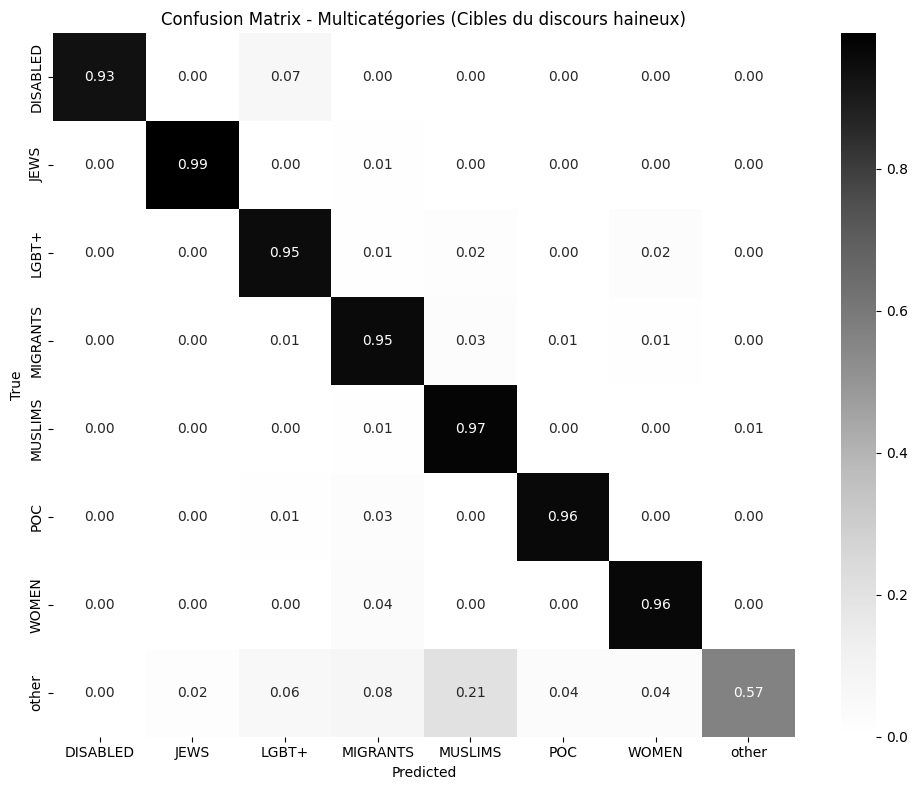

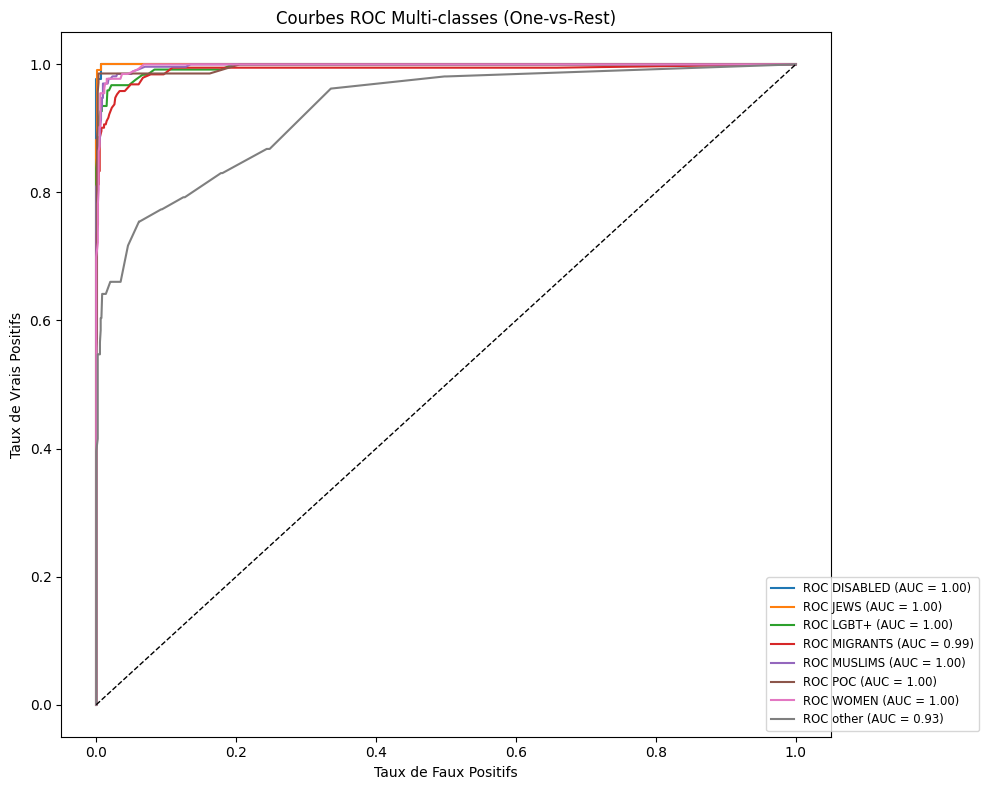

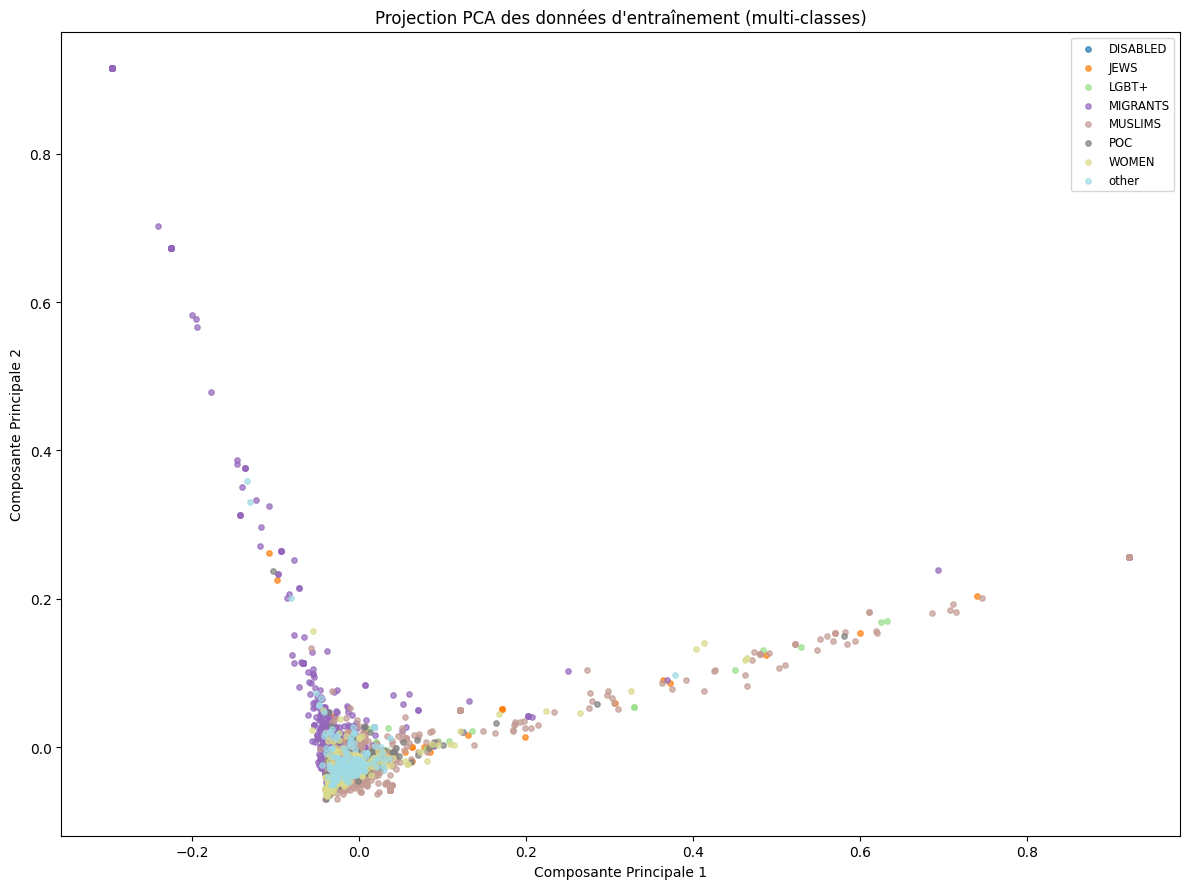

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Chargement des données
data = pd.read_csv("Multitarget-CONAN.csv")
data = data[['HATE_SPEECH', 'TARGET']].dropna()
data = data[data['TARGET'] != 'none']  # Supprimer les lignes sans cible claire

# 2. Nettoyage du texte
def preprocess(text_string):
    text_string = re.sub(r"http\S+", "", text_string)  # supprimer URLs
    text_string = re.sub(r"@\w+", "", text_string)     # supprimer mentions
    text_string = re.sub(r"#\w+", "", text_string)     # supprimer hashtags
    text_string = re.sub(r"[^A-Za-z0-9\s]", "", text_string)  # supprimer ponctuation
    text_string = re.sub(r"\s+", " ", text_string).strip()
    return text_string.lower()

data['clean_text'] = data['HATE_SPEECH'].astype(str).apply(preprocess)

# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['TARGET'], test_size=0.2, stratify=data['TARGET'], random_state=42
)

# 4. TF-IDF vectorisation
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 5. Modèle
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
model.fit(X_train_tfidf, y_train)

# 6. Prédictions
y_pred = model.predict(X_test_tfidf)

# 7. Rapport
print(classification_report(y_test, y_pred))

# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = sorted(data['TARGET'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Multicatégories (Cibles du discours haineux)")
plt.tight_layout()
plt.show()


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

# --- Courbe ROC multi-classes (One-vs-Rest) --- #

# Binarisation des labels pour ROC
classes = sorted(data['TARGET'].unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test_tfidf)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multi-classes (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small', bbox_to_anchor=(1.2, 0))
plt.tight_layout()
plt.show()

# --- PCA pour visualiser les données --- #
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(12, 9))
unique_labels = np.unique(y_train)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for idx, label in enumerate(unique_labels):
    plt.scatter(X_pca[y_train == label, 0], X_pca[y_train == label, 1],
                color=colors[idx], label=label, alpha=0.7, s=15)

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection PCA des données d\'entraînement (multi-classes)')
plt.legend(loc='best', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()



## **Logistic Regression sur Multitarget Conan**

              precision    recall  f1-score   support

    DISABLED       0.98      0.93      0.95        44
        JEWS       0.98      0.97      0.98       119
       LGBT+       0.96      0.94      0.95       123
    MIGRANTS       0.92      0.92      0.92       192
     MUSLIMS       0.93      0.98      0.95       267
         POC       0.89      0.97      0.93        70
       WOMEN       0.95      0.95      0.95       133
       other       0.81      0.57      0.67        53

    accuracy                           0.93      1001
   macro avg       0.93      0.90      0.91      1001
weighted avg       0.93      0.93      0.93      1001



<ipython-input-11-04880f80b660>:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


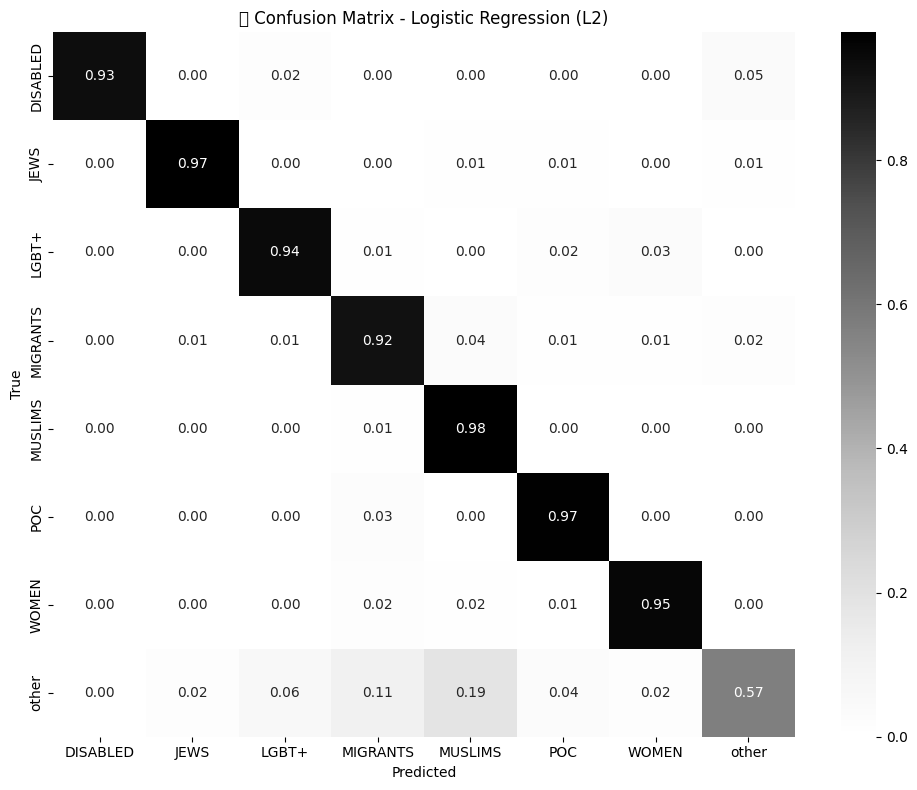

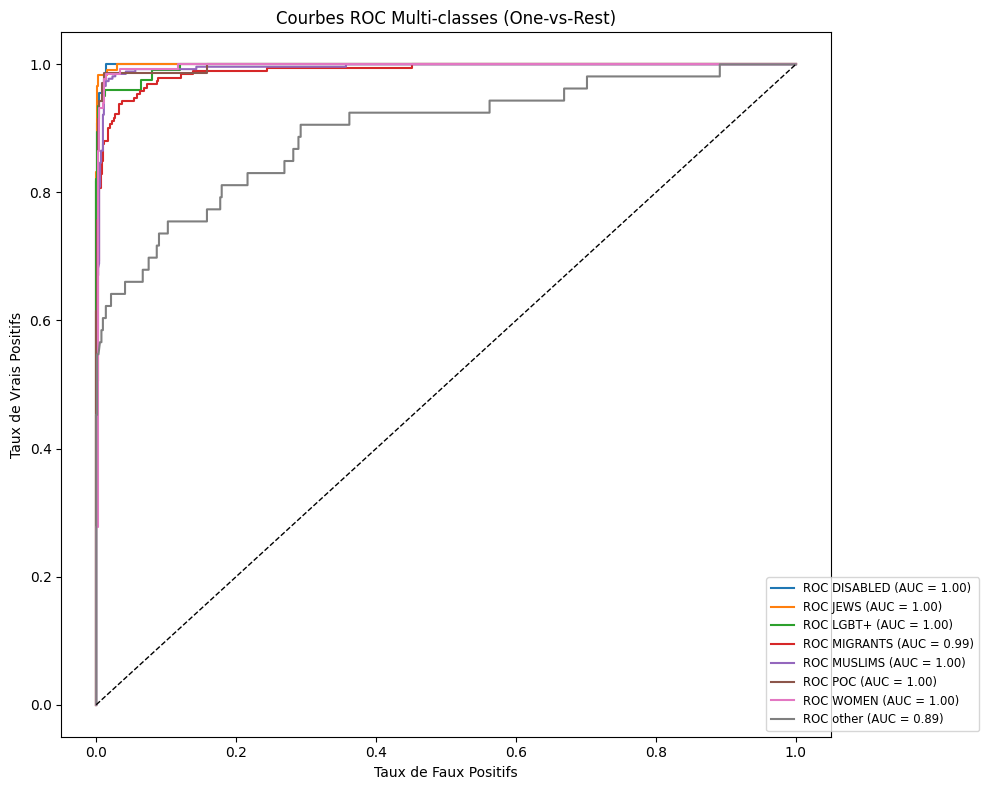

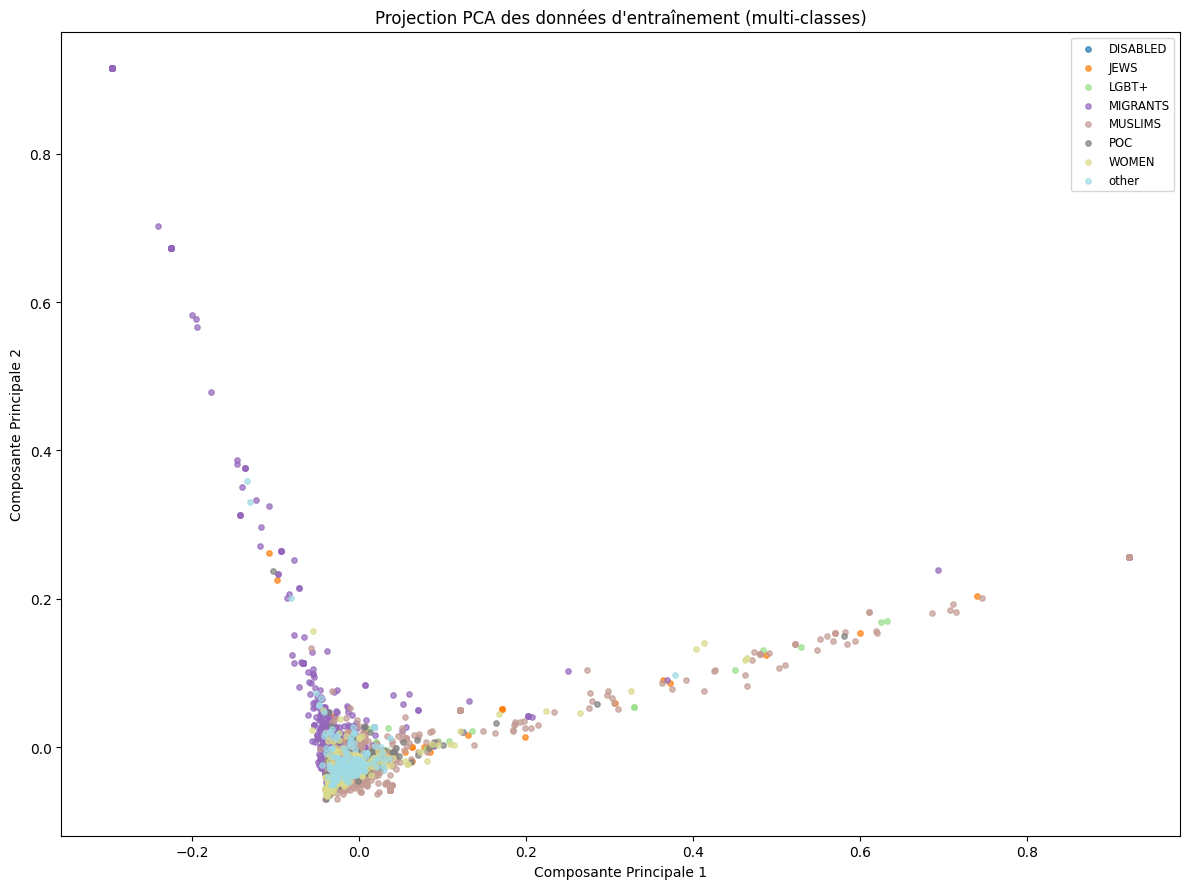

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# 1. Chargement des données
data = pd.read_csv("Multitarget-CONAN.csv")
data = data[['HATE_SPEECH', 'TARGET']].dropna()
data = data[data['TARGET'] != 'none']

# 2. Prétraitement texte
def preprocess(text_string):
    text_string = re.sub(r"http\S+", "", text_string)
    text_string = re.sub(r"@\w+", "", text_string)
    text_string = re.sub(r"#\w+", "", text_string)
    text_string = re.sub(r"[^A-Za-z0-9\s]", "", text_string)
    text_string = re.sub(r"\s+", " ", text_string).strip()
    return text_string.lower()

data['clean_text'] = data['HATE_SPEECH'].astype(str).apply(preprocess)

# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['TARGET'], test_size=0.2, stratify=data['TARGET'], random_state=42
)

# 4. TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_df=0.9)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# 5. Modèle Logistic Regression (L2 regularization)
model = LogisticRegression(
    penalty='l2',
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    C=1.0,
    random_state=42
)
model.fit(X_train_tfidf, y_train)

# 6. Prédictions
y_pred = model.predict(X_test_tfidf)

# 7. Rapport
print(classification_report(y_test, y_pred))

# 8. Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
labels = sorted(data['TARGET'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("📊 Confusion Matrix - Logistic Regression (L2)")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA

# --- Courbe ROC multi-classes (One-vs-Rest) --- #

# Binarisation des labels pour ROC
classes = sorted(data['TARGET'].unique())
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test_tfidf)

plt.figure(figsize=(10, 8))
for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1.5, label=f'ROC {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbes ROC Multi-classes (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small', bbox_to_anchor=(1.2, 0))
plt.tight_layout()
plt.show()

# --- PCA pour visualiser les données --- #
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(12, 9))
unique_labels = np.unique(y_train)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

for idx, label in enumerate(unique_labels):
    plt.scatter(X_pca[y_train == label, 0], X_pca[y_train == label, 1],
                color=colors[idx], label=label, alpha=0.7, s=15)

plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection PCA des données d\'entraînement (multi-classes)')
plt.legend(loc='best', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout()
plt.show()



# **4. Evaluation Complémentaire (Find tuning + Features importances)**

## **Features Importances**

Rapport final - Logistic Regression L2 (2 niveaux)
              precision    recall  f1-score   support

        Hate       0.50      0.80      0.62      1430
   Offensive       0.97      0.91      0.94     19190
     Neither       0.82      0.88      0.85      4163

    accuracy                           0.90     24783
   macro avg       0.77      0.87      0.80     24783
weighted avg       0.92      0.90      0.91     24783



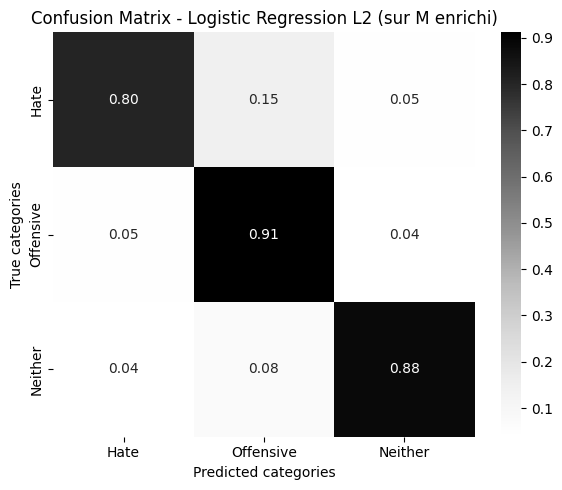

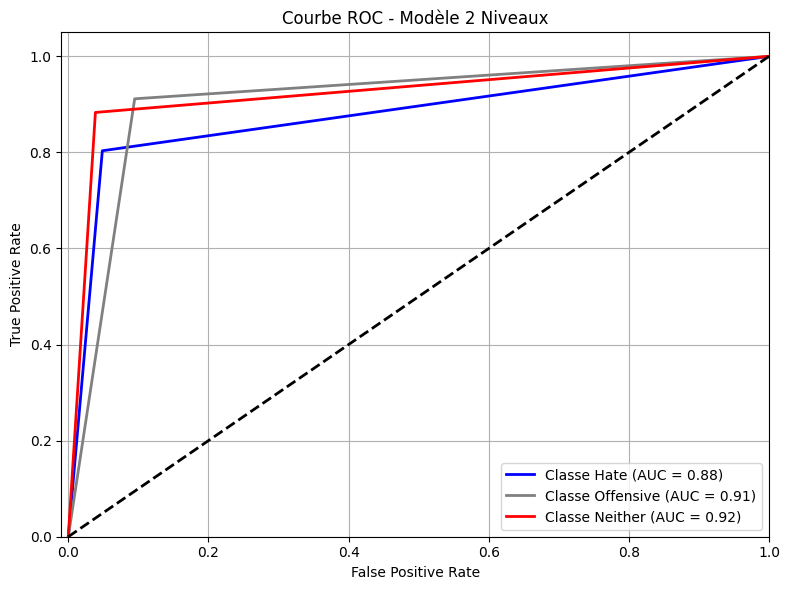

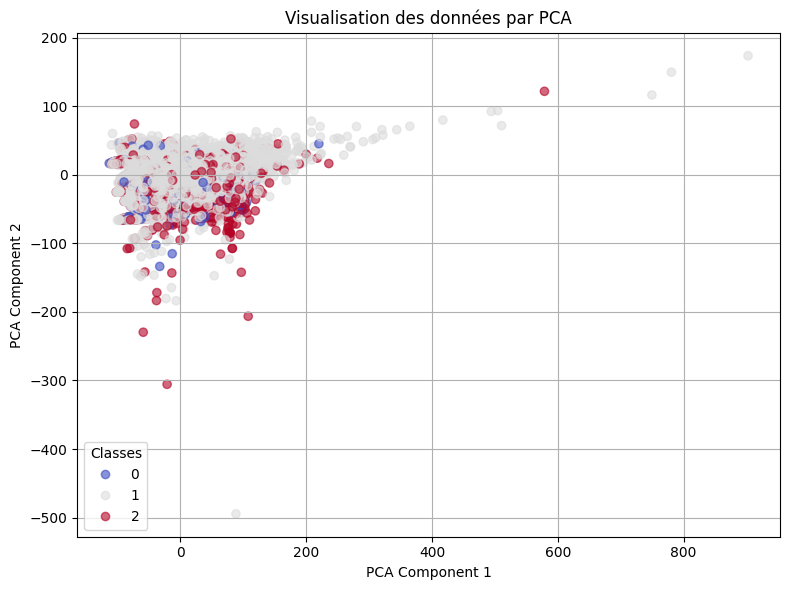

=== Importance des features - Niveau 1 ===


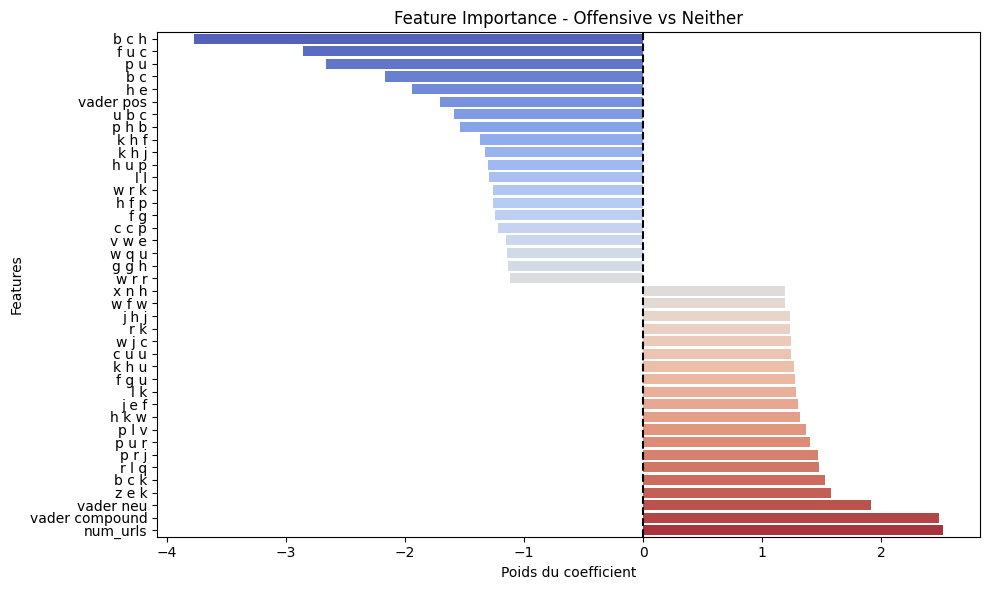

=== Importance des features - Niveau 2 ===


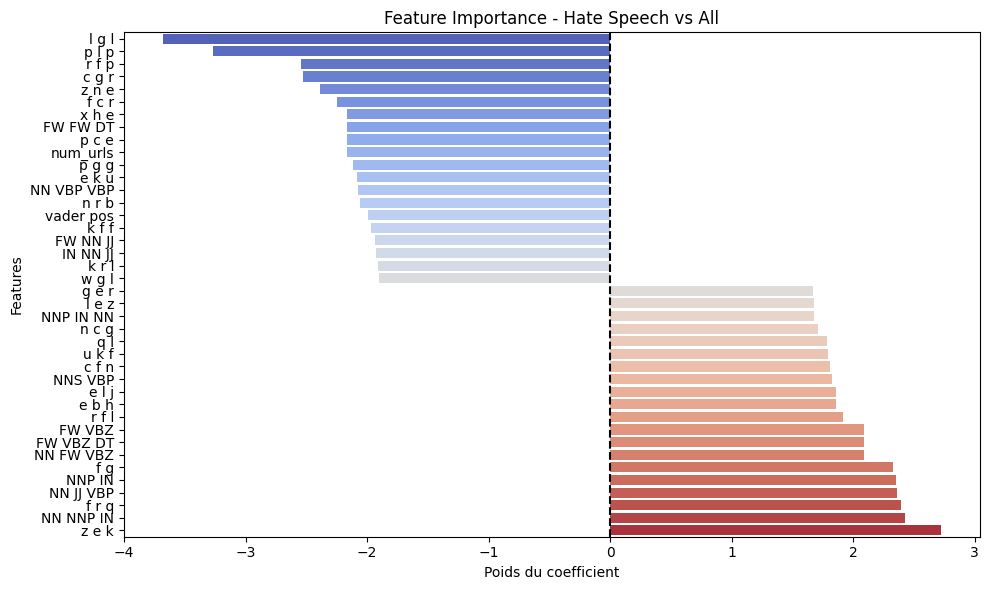

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Chargement des features enrichies (M) et des classes
X_full = pd.DataFrame(M)
y_full = data['class']

# --- Niveau 1 : Offensive (1) vs Neither (2)
mask_lvl1 = y_full.isin([1, 2])
X_lvl1 = X_full[mask_lvl1]
y_lvl1 = y_full[mask_lvl1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X_lvl1, y_lvl1, test_size=0.3, random_state=42)

clf_lvl1 = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    C=1.0
)
clf_lvl1.fit(X1_train, y1_train)

# --- Niveau 2 : Hate Speech (0) vs le reste
y_lvl2 = y_full.apply(lambda x: 1 if x == 0 else 0)  # 1 = Hate, 0 = All others
X2_train, X2_test, y2_train, y2_test = train_test_split(X_full, y_lvl2, test_size=0.3, random_state=42)

# Oversampling classe 1 (Hate Speech)
ros = RandomOverSampler(random_state=42)
X2_train_ros, y2_train_ros = ros.fit_resample(X2_train, y2_train)

clf_lvl2 = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    C=1.0
)
clf_lvl2.fit(X2_train_ros, y2_train_ros)

# === Prédictions finales ===
pred_lvl2 = clf_lvl2.predict(X_full)

final_preds = []
for i in range(len(X_full)):
    if pred_lvl2[i] == 1:
        final_preds.append(0)  # Hate Speech
    else:
        pred_lvl1 = clf_lvl1.predict(X_full.iloc[[i]])[0]
        final_preds.append(pred_lvl1)  # Offensive or Neither

# === Évaluation ===
print("Rapport final - Logistic Regression L2 (2 niveaux)")
print(classification_report(y_full, final_preds, target_names=['Hate', 'Offensive', 'Neither']))

# Matrice de confusion
cm = confusion_matrix(y_full, final_preds, normalize='true')
labels = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted categories")
plt.ylabel("True categories")
plt.title("Confusion Matrix - Logistic Regression L2 (sur M enrichi)")
plt.tight_layout()
plt.show()

# === ROC CURVE Multiclasse ===
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarisation des vraies classes et des prédictions
y_full_bin = label_binarize(y_full, classes=[0, 1, 2])
final_preds_bin = label_binarize(final_preds, classes=[0, 1, 2])

# Calcul de la courbe ROC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_full_bin[:, i], final_preds_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer la ROC
plt.figure(figsize=(8, 6))
colors = ['blue', 'grey', 'red']
labels_names = ['Hate', 'Offensive', 'Neither']

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Classe {labels_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - Modèle 2 Niveaux')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# === Analyse PCA ===
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, cmap='coolwarm', alpha=0.6)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualisation des données par PCA')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid()
plt.tight_layout()
plt.show()

def plot_feature_importance(coef, feature_names, title, top_n=20):
    """
    Affiche les top_n features les plus positives et négatives selon les coefficients
    """
    coef = coef.flatten()
    top_positive_idx = np.argsort(coef)[-top_n:]
    top_negative_idx = np.argsort(coef)[:top_n]

    top_features_idx = np.concatenate([top_negative_idx, top_positive_idx])
    top_features_names = [feature_names[i] for i in top_features_idx]
    top_features_weights = coef[top_features_idx]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_features_weights, y=top_features_names, palette="coolwarm")
    plt.title(title)
    plt.xlabel("Poids du coefficient")
    plt.ylabel("Features")
    plt.axvline(0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

# Importance des features pour le niveau 1 (Offensive vs Neither)
print("=== Importance des features - Niveau 1 ===")
plot_feature_importance(clf_lvl1.coef_, feature_names, "Feature Importance - Offensive vs Neither")

# Importance des features pour le niveau 2 (Hate Speech vs le reste)
print("=== Importance des features - Niveau 2 ===")
plot_feature_importance(clf_lvl2.coef_, feature_names, "Feature Importance - Hate Speech vs All")



# **Courbe ROC des modèles**

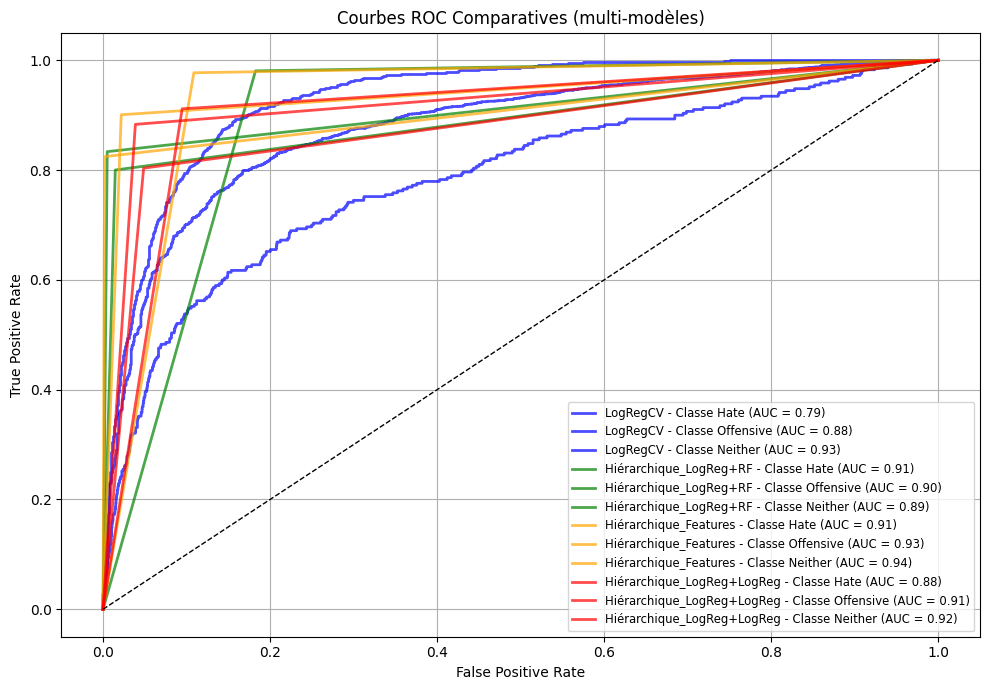

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Liste des modèles à comparer
roc_data = [
    (nom_modele_lr, y_true_bin_lr, y_score_lr),
    (nom_modele_hier1, y_true_bin_hier1, y_score_hier1),
    (nom_modele_hier2, y_true_bin_hier2, y_score_hier2),
    (nom_modele_loglog, y_true_bin_loglog, y_score_loglog),
]

# Couleurs pour chaque modèle
colors = ['blue', 'green', 'orange', 'red']
classes = ['Hate', 'Offensive', 'Neither']

plt.figure(figsize=(10, 7))
for (name, y_true_bin, y_score), color in zip(roc_data, colors):
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color=color, alpha=0.7,
                 label=f"{name} - Classe {classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbes ROC Comparatives (multi-modèles)')
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


# **5. Rap Fr anayse technique et philosophique**



Rapport - Logistic Regression sur données enrichies
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        31
           1       0.66      0.70      0.68        30

    accuracy                           0.67        61
   macro avg       0.67      0.67      0.67        61
weighted avg       0.67      0.67      0.67        61



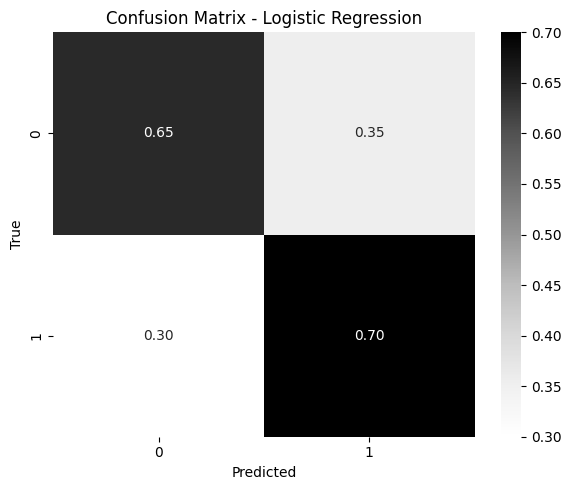

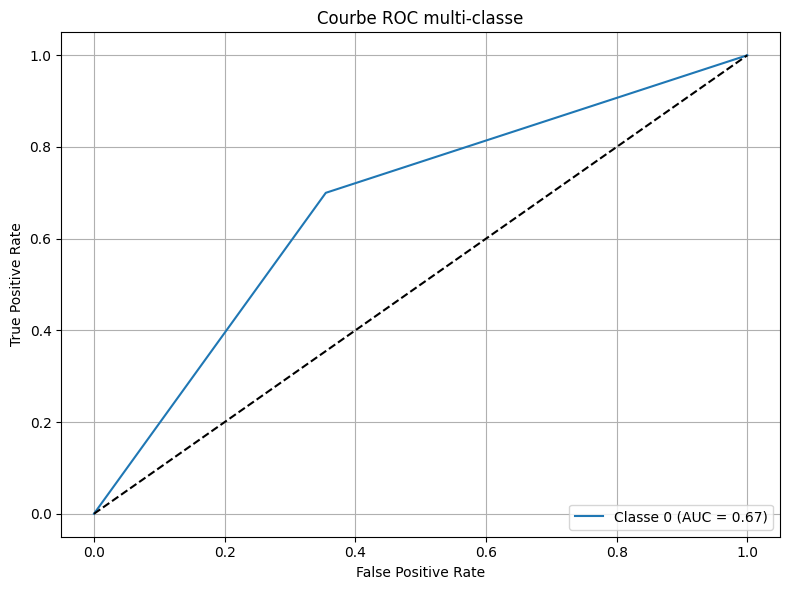

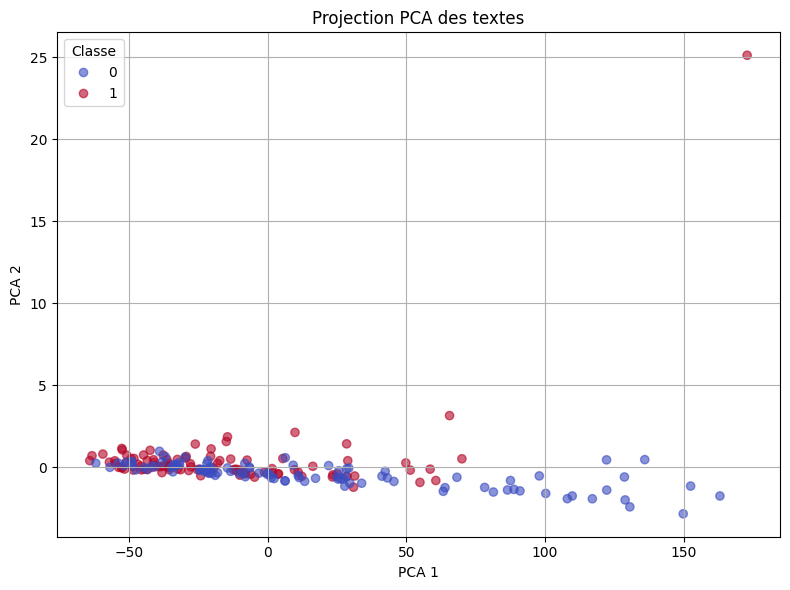

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer

# Chargement du dataset
df = pd.read_excel("HaineRapFr.xlsx")

# Nettoyage basique
df = df.dropna(subset=["Paroles", "Label"])
df['Paroles'] = df['Paroles'].astype(str)
df['Label'] = df['Label'].astype(int)

# Liste simple de mots offensifs
grossieretes = ["pute", "nique", "encul", "salope", "fdp", "merde", "con", "batard", "bougnoule", "pd", "pédé", "chien", "ta mère"]

def extract_features(text):
    words = text.split()
    nb_chars = len(text)
    nb_words = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if words else 0
    nb_badwords = sum(text.lower().count(word) for word in grossieretes)
    nb_lines = text.count('\n')
    caps_ratio = sum(1 for c in text if c.isupper()) / len(text) if text else 0
    return [nb_chars, nb_words, avg_word_len, nb_badwords, nb_lines, caps_ratio]

feature_names = ['nb_chars', 'nb_words', 'avg_word_len', 'nb_badwords', 'nb_lines', 'caps_ratio']
features = np.array([extract_features(p) for p in df['Paroles']])

# TF-IDF simplifié
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=3, max_features=3000)
X_tfidf = vectorizer.fit_transform(df['Paroles']).toarray()

# Features totales
X_full = np.concatenate([X_tfidf, features], axis=1)
y_full = df['Label']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, stratify=y_full, random_state=42)

# Modèle Logistic Regression
model = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    max_iter=1000,
    C=1.0
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Rapport
print("Rapport - Logistic Regression sur données enrichies")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

# ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_full))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_full))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(y_test_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], label=f"Classe {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC multi-classe")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_full, cmap='coolwarm', alpha=0.6)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Projection PCA des textes')
plt.legend(*scatter.legend_elements(), title="Classe")
plt.tight_layout()
plt.grid()
plt.show()


Index(['Rappeur', 'Son', 'Paroles', 'Label', 'clean_text'], dtype='object')
              precision    recall  f1-score   support

      Neutre       0.56      0.78      0.65       103
     Haineux       0.61      0.37      0.46        98

    accuracy                           0.58       201
   macro avg       0.59      0.57      0.56       201
weighted avg       0.59      0.58      0.56       201



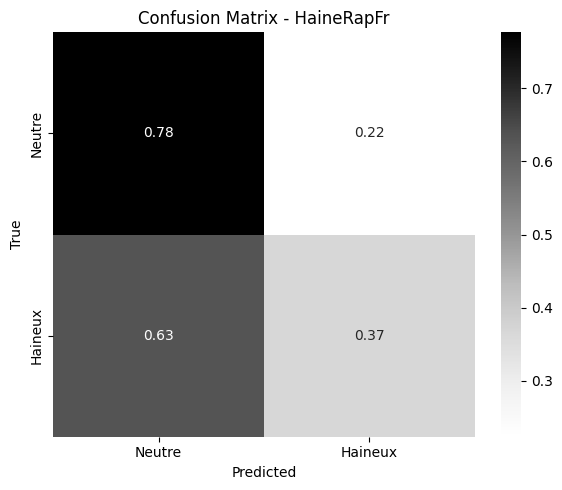

In [ ]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack

# 1. Charger la base d'entraînement
data_train = pd.read_csv("FTR_new_labels.csv", encoding='latin-1')

# Charger la base de test (HaineRapFr)
data_test = pd.read_excel("HaineRapFr.xlsx")

# 2. Nettoyage et enrichissement
def preprocess(text_string):
    text_string = re.sub(r"http\S+", "", text_string)
    text_string = re.sub(r"@\w+", "", text_string)
    text_string = re.sub(r"#\w+", "", text_string)
    text_string = re.sub(r"[^A-Za-z0-9\s]", "", text_string)
    text_string = re.sub(r"\s+", " ", text_string).strip()
    return text_string.lower()

def extra_features(text):
    length = len(text)
    word_count = len(text.split())
    upper_count = sum(1 for c in text if c.isupper())
    exclamations = text.count("!")
    questions = text.count("?")
    return [length, word_count, upper_count, exclamations, questions]

# Appliquer le nettoyage
data_train['clean_text'] = data_train['tweet'].astype(str).apply(preprocess)
data_test['clean_text'] = data_test['Paroles'].astype(str).apply(preprocess)

# Extra features
train_extra_feats = np.array(data_train['tweet'].astype(str).apply(extra_features).tolist())
test_extra_feats = np.array(data_test['Paroles'].astype(str).apply(extra_features).tolist())

# 3. Split d'entraînement uniquement
X_train_text = data_train['clean_text']
X_train_feats = train_extra_feats
y_train = data_train['label']

# Données de test : textes et labels si dispo
X_test_text = data_test['clean_text']
X_test_feats = test_extra_feats

# 4. TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# 5. Fusion TF-IDF + autres features
X_train_combined = hstack([X_train_tfidf, X_train_feats])
X_test_combined = hstack([X_test_tfidf, X_test_feats])

# 6. Modèle Logistic Regression
model = LogisticRegression(
    solver='liblinear',
    penalty='l2',
    class_weight='balanced',
    C=1.0,
    max_iter=1000
)
model.fit(X_train_combined, y_train)

# 7. Prédictions sur HaineRapFr
y_pred = model.predict(X_test_combined)
print(data_test.columns)
# 8. Si le fichier contient une colonne "label", afficher le rapport
if 'Label' in data_test.columns:
    print(classification_report(data_test['Label'], y_pred, target_names=['Neutre', 'Haineux']))

    # 9. Matrice de confusion
    cm = confusion_matrix(data_test['Label'], y_pred, normalize='true')
    labels = ['Neutre', 'Haineux']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greys', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - HaineRapFr")
    plt.tight_layout()
    plt.show()
else:
    print("Aucune colonne 'Label' dans HaineRapFr.xlsx. Prédictions générées, mais pas de métriques d'évaluation.")
